# Mask R-CNN (ARDIS)

---
## Importovanie modulov:

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage

---
## Importovanie Mask R-CNN modulov:

In [2]:
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

2022-05-09 12:18:03.185887: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


---
## Nastavenie počiatočných ciest (logy, pred-trénovaný model):

In [3]:
# Nastavenie koreňového priečinka implementácie MASK R-CNN
ROOT_DIR = "mask_rcnn_aktwelve"
# Import MASK R-CNN knižníc
sys.path.append(ROOT_DIR)
# Vytvorenie priečinka na uloženie logov a výsledného natrénovaného modelu MASK R-CNN
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Cesta k pred-trénovanému referenčnému modelu
COCO_MODEL_FILE = "mask_rcnn_coco.h5"
# Stiahnutie pred-trénovaného referenčného modelu, ak neexistuje
if not os.path.exists(COCO_MODEL_FILE):
    utils.download_trained_weights(COCO_MODEL_FILE)

---
## Trénovanie - konfigurácia modelu:

In [4]:
class DigitsConfig(Config):
 
    NAME = "HandwrittenDigits"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    NUM_CLASSES = 10 + 1  # 10 číslic + pozadie
    STEPS_PER_EPOCH = 800
    VALIDATION_STEPS = 50
    LEARNING_RATE = 0.0001
    
    BACKBONE = "resnet50"
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    IMAGE_CHANNEL_COUNT = 3
    MEAN_PIXEL = np.array([143.62647976011993,143.62647976011993,143.62647976011993])

    
config = DigitsConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

---
## Definícia COCO formátu:

In [5]:
class CocoLikeDataset(utils.Dataset):
    
    # Načítanie dát (obrázkov) a anotácii
    def load_data(self, annotation_json, images_dir):
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Pridanie mien jednotlivých tried
        source_name = "coco_like"
        for category in coco_json["categories"]:
            class_id = category["id"]
            class_name = category["name"]
            if class_id < 1:
                print(f"Error: Class id for {class_name} cannot be less than one. (0 is reserved for the background)")
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Získanie všetkých anotácii
        annotations = {}
        for annotation in coco_json["annotations"]:
            image_id = annotation["image_id"]
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Získanie všetkých dát (obrázkov)
        seen_images = {}
        for image in coco_json["images"]:
            image_id = image["id"]
            if image_id in seen_images:
                print(f"Warning: Skipping duplicate image id: {image}")
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image["file_name"]
                    image_width = image["width"]
                    image_height = image["height"]
                except KeyError as key:
                    print(f"Warning: Skipping image (id: {image_id}) with missing key: {key}")
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Pridanie obrázka
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
    
    # Načítanie masiek z anotácii
    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        annotations = image_info["annotations"]
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation["category_id"]
            mask = Image.new("1", (image_info["width"], image_info["height"]))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation["segmentation"]:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

---
## Načítanie datasetov (trénovanie/validácia):

In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data("./datasets/ardis/train/labels.json", "./datasets/ardis/train/images")
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data("./datasets/ardis/val/labels.json", "./datasets/ardis/val/images")
dataset_val.prepare()

---
## Vizualizácia vzoriek dát (číslic):

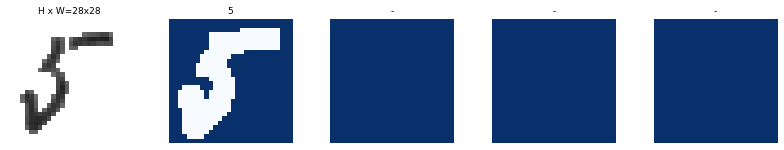

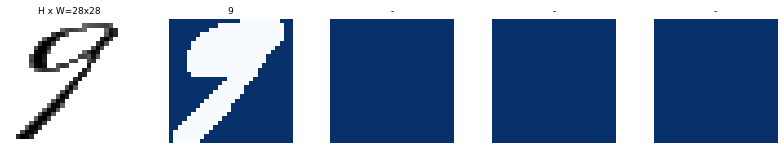

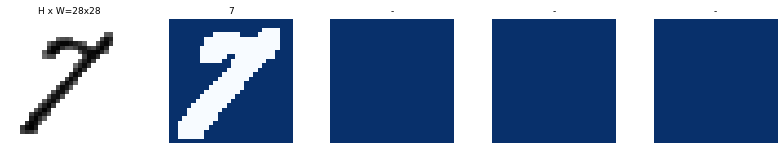

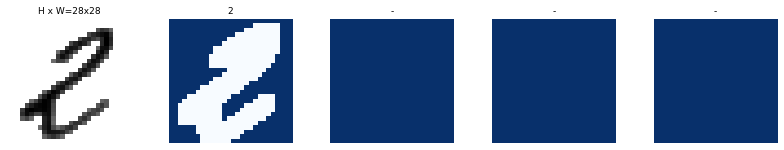

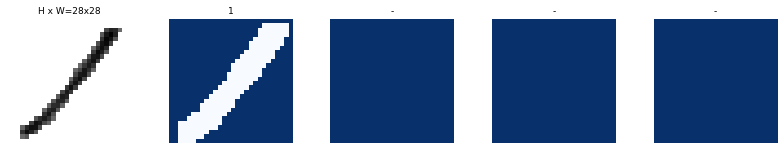

In [7]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 5)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

---
## Trénovanie - vytvorenie modelu:

In [8]:
# Vytvorenie modelu v tréningovom móde
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


2022-05-09 12:18:33.528248: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-05-09 12:18:33.584196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.645GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-05-09 12:18:33.584246: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-09 12:18:33.609470: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-05-09 12:18:33.609547: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-05-09 12:18:33.637513: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library li

In [10]:
# Inicializácia počiatočných váh
init_with = "coco"  # "imagenet", "coco", alebo "last"

#Načítaie váh typu "imagenet" 
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
#Načítaie váh typu "coco" 
elif init_with == "coco":
    model.load_weights(COCO_MODEL_FILE, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
#Načítaie posledných natrénovaných váh
elif init_with == "last":
    model.load_weights(model.find_last(), by_name=True)

2022-05-09 12:18:57.701850: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-09 12:18:57.717516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.645GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2022-05-09 12:18:57.718873: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-05-09 12:18:57.724466: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-05-09 12:18:58.782758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device inte

---
## Trenovanie - spustenie trénovania modelu:

In [11]:
# Trénovaie "heads" predtrénovanej COCO siete
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10,
            layers="heads")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f"Training took {minutes} minutes")


Starting at epoch 0. LR=0.0001

Checkpoint Path: mask_rcnn_aktwelve/logs/handwrittendigits20220509T1219/mask_rcnn_handwrittendigits_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
m

/home/filipmikus/anaconda3/envs/mask_rcnn/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/home/filipmikus/anaconda3/envs/mask_rcnn/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/filipmikus/anaconda3/envs/mask_rcnn/lib/python3.9/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validat

Epoch 1/10


/home/filipmikus/anaconda3/envs/mask_rcnn/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/filipmikus/anaconda3/envs/mask_rcnn/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradie

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/Conv2D}}]]
	 [[proposal_targets/strided_slice_165/_2871]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

---
## Inferencia - konfigurácia modelu:

In [52]:
class InferenceDigitsConfig(DigitsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    DETECTION_MIN_CONFIDENCE = 0.3
    
inference_config = InferenceDigitsConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.3
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                23
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

---
## Inferencia - vytvorenie modelu:

In [53]:
inference_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

In [54]:
# Načítanie natrénovanej siete, respektíve jej váh v .h5 súbore
model_path = model.find_last()

assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
inference_model.load_weights(model_path, by_name=True)

Loading weights from  mask_rcnn_aktwelve/logs/handwrittendigits20220416T1020/mask_rcnn_handwrittendigits_0050.h5
Re-starting from epoch 50


---
## Inferencia - spustenie inferencie na ARDIS 1x1 vzorkách:

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
0


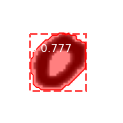

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
3


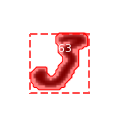

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
1


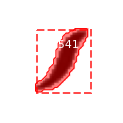

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9


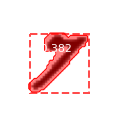

In [55]:
real_test_dir = "./datasets/ardis/test/digits_1x1"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 4:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(2, 2))

---
## Inferencia - spustenie inferencie na MNIST 1x1 vzorkách:

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -141.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
2


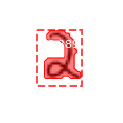

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
2


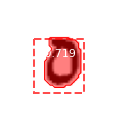

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
3
2
4


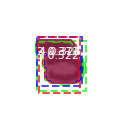

Processing 1 images
image                    shape: (28, 28, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -142.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
2


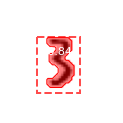

In [56]:
real_test_dir = "./datasets/mnist/test/digits_1x1"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 4:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(2, 2))

---
## Inferencia - spustenie inferencie na ARDIS 2x2 vzorkách:

Processing 1 images
image                    shape: (56, 56, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
9
9


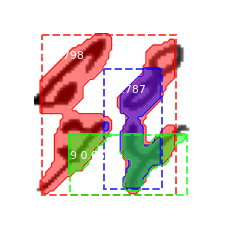

Processing 1 images
image                    shape: (56, 56, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
9
2


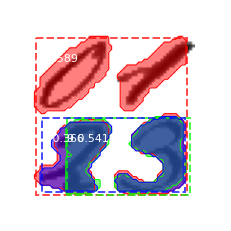

Processing 1 images
image                    shape: (56, 56, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
9
9
9


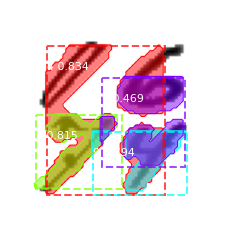

Processing 1 images
image                    shape: (56, 56, 3)           min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
4
9
9


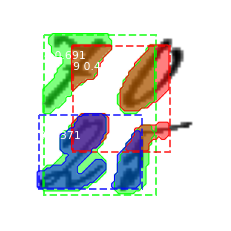

In [57]:
real_test_dir = "./datasets/ardis/test/digits_2x2"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 4:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(4,4))

---
## Inferencia - spustenie inferencie na ARDIS 4x4 vzorkách:

Processing 1 images
image                    shape: (112, 112, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9
9
9
9
9
9
9
9
9
4
4
4
9
9
9
9
3


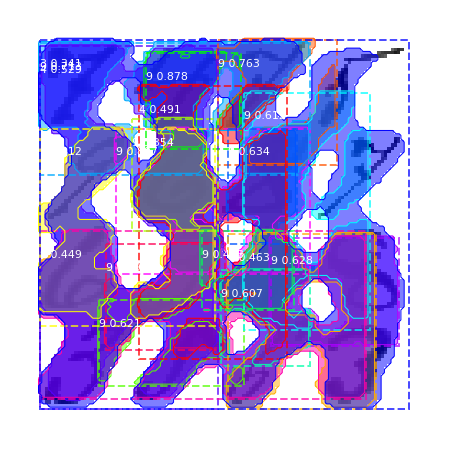

Processing 1 images
image                    shape: (112, 112, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9
9
9
9
9
9
9
9
9
9
4


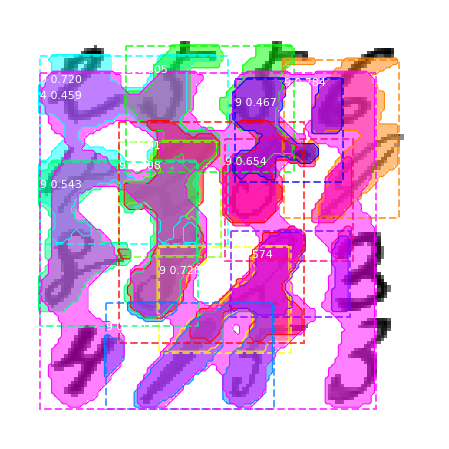

Processing 1 images
image                    shape: (112, 112, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9
9
9
9
9
9
9
9
9
9
4
4
4


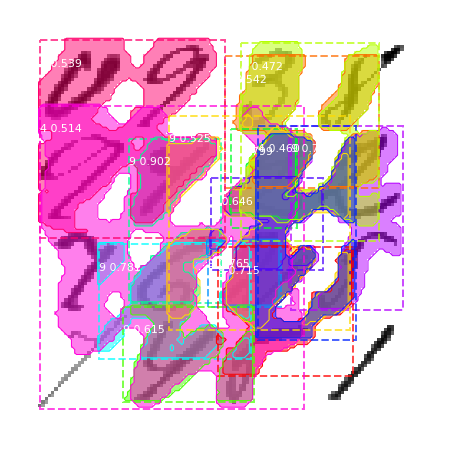

Processing 1 images
image                    shape: (112, 112, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9
9
9
9
4
9
9
9
4
9
9
4
9
9
4
9
4
9


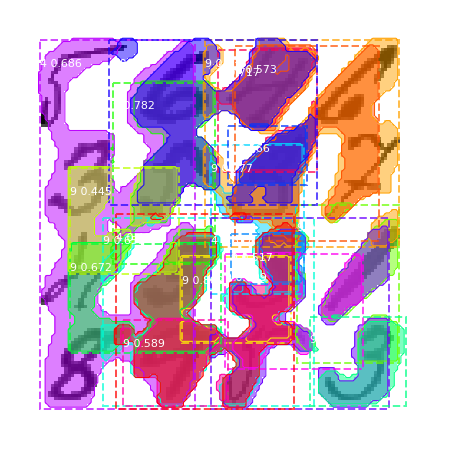

In [58]:
real_test_dir = "./datasets/ardis/test/digits_4x4"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 4:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(8,8))

---
## Inferencia - spustenie inferencie na ARDIS 8x8 vzorkách:

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  224.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9


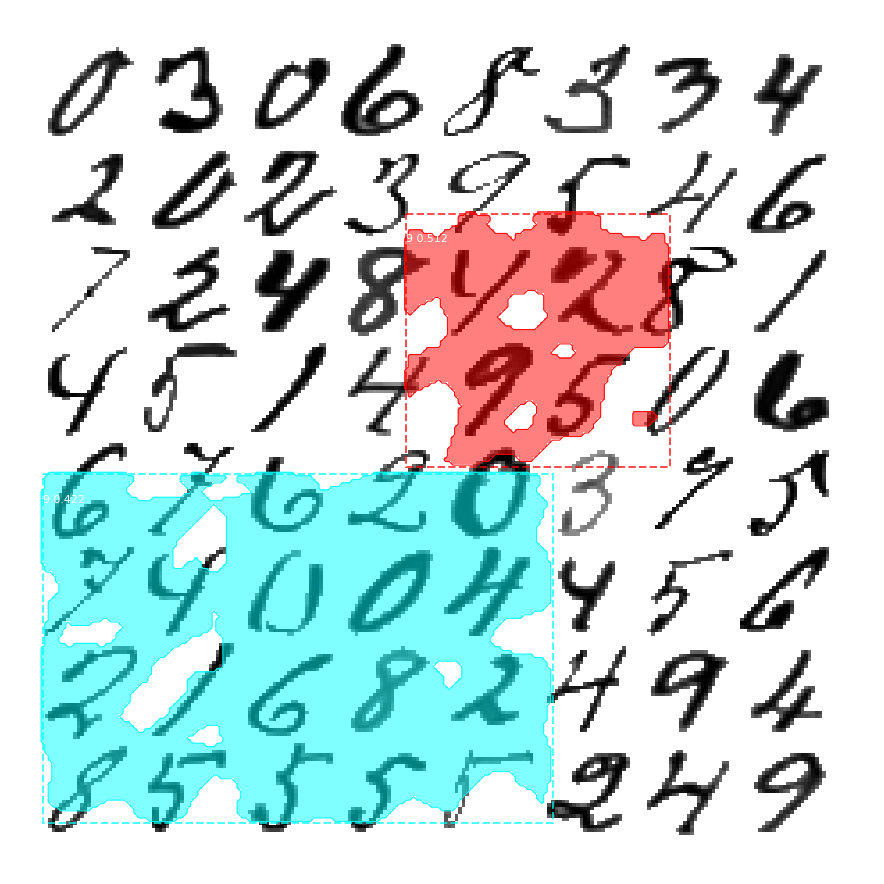

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  224.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9
9
9
9
4


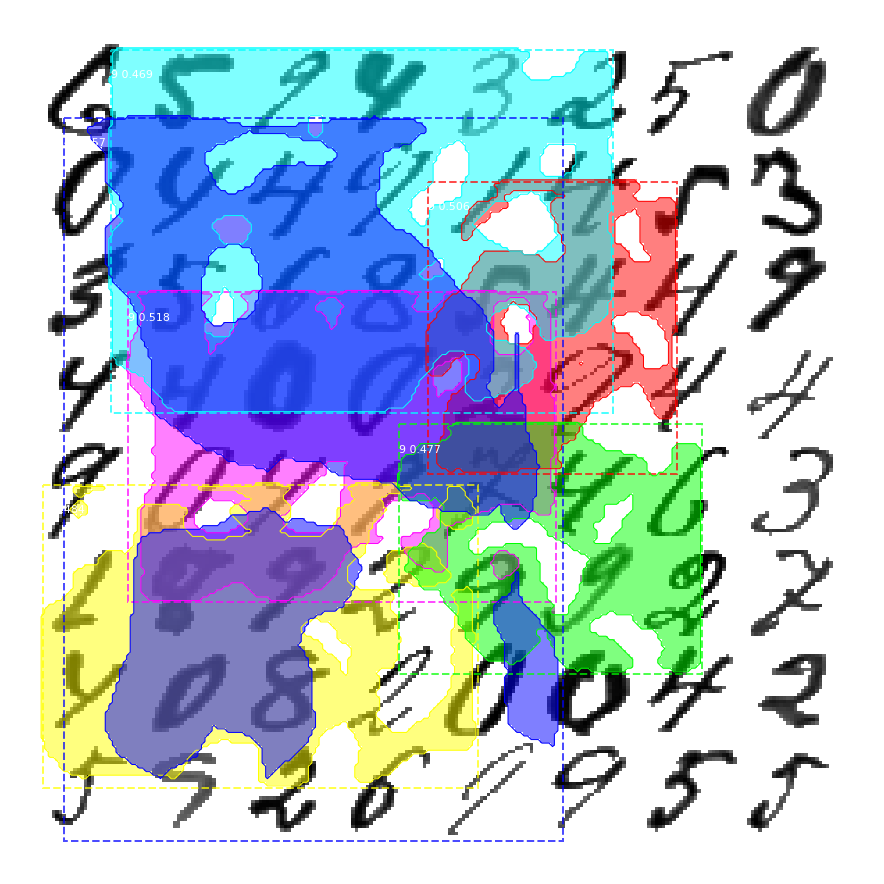

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  224.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9


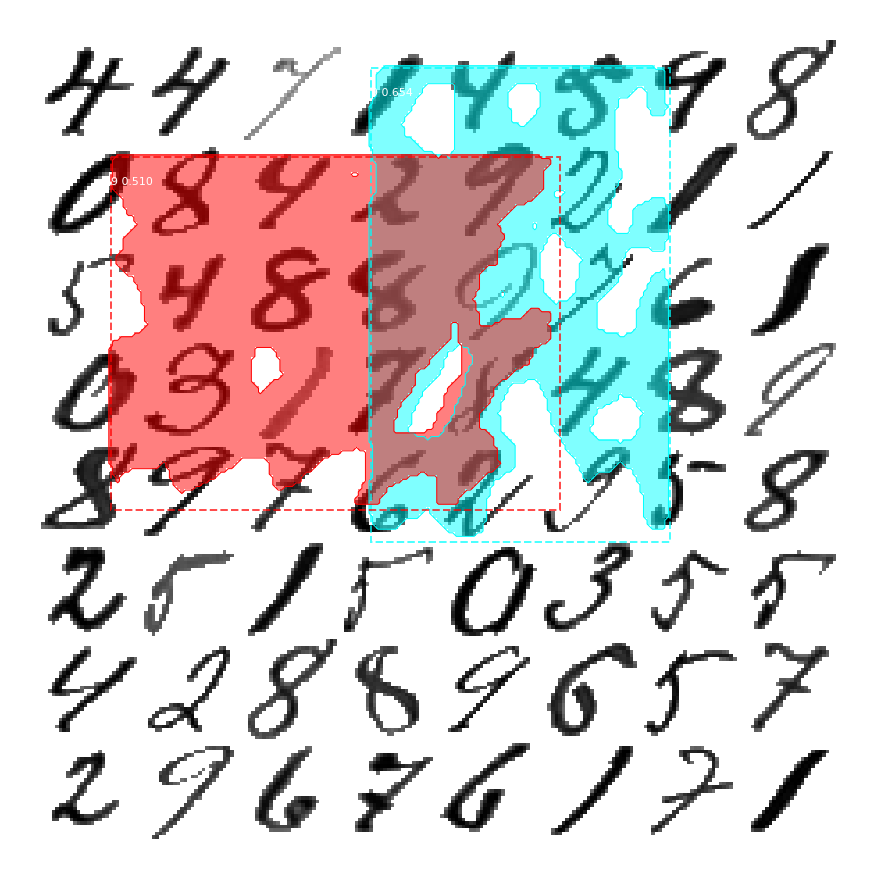

Processing 1 images
image                    shape: (224, 224, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -143.62648  max:  111.37352  float64
image_metas              shape: (1, 23)               min:    0.00000  max:  224.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32
9
9


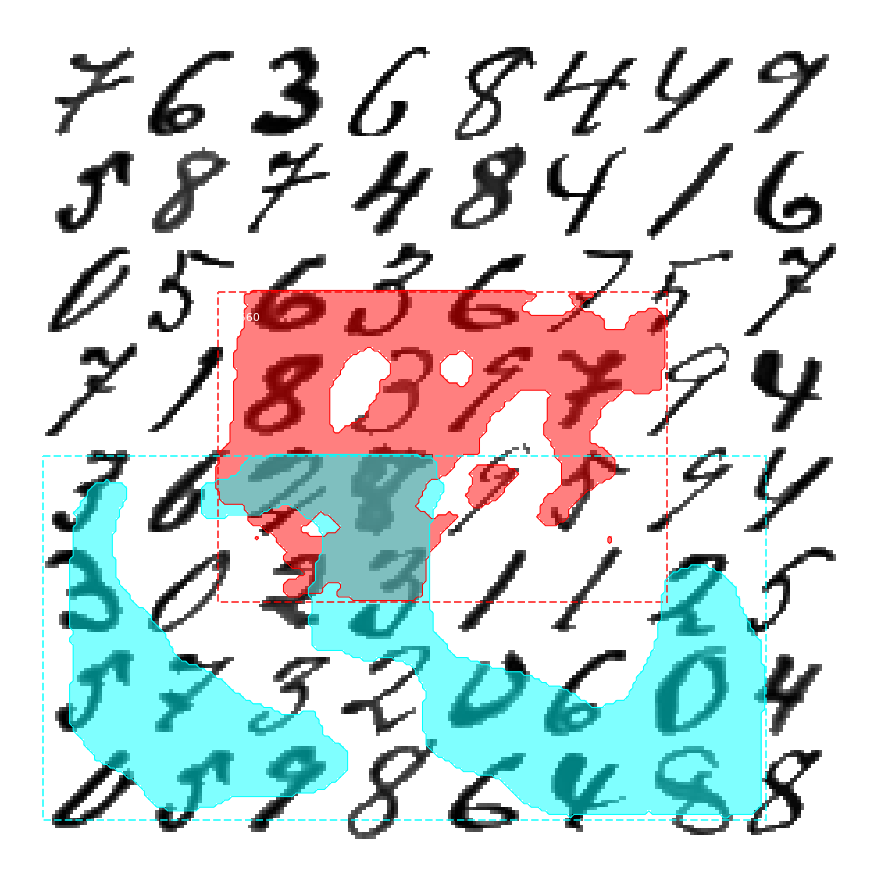

In [59]:
real_test_dir = "./datasets/ardis/test/digits_8x8"
image_paths = []
class_names = ['BG', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
i = 0 

for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in [".png", ".jpg", ".jpeg"]:
        image_paths.append(os.path.join(real_test_dir, filename))
    i += 1
    if i == 4:
        break

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = inference_model.detect([img_arr], verbose=1)
    r = results[0]
    for cls_id in r["class_ids"]:
        print(class_names[int(cls_id)])
    visualize.display_instances(img, r["rois"], r["masks"], r["class_ids"], 
                                class_names, r["scores"], figsize=(16,16))